### Setup

In [9]:
import os
import osmnx as ox
import networkx as nx
from graph_search import *
from search import *
import networkx as nx
import pickle
import numpy as np

In [10]:
# Armenia Cities
with open(r"graphs/armenia_cities.pkl", "rb") as f:
    armenia_cities_graph = pickle.load(f)

# Armenia Cities & Villages
with open(r"graphs/armenia_cities_villages.pkl", "rb") as f:
    armenia_cities_villages_graph = pickle.load(f)

# Yerevan
with open(r"graphs/yerevan.pkl", "rb") as f:
    yerevan_graph = pickle.load(f)

In [11]:
print("Cities:", armenia_cities_graph.number_of_nodes(), "nodes")
print("Cities & Villages:", armenia_cities_villages_graph.number_of_nodes(), "nodes")
print("Yerevan:", yerevan_graph.number_of_nodes(), "nodes")

Cities: 50 nodes
Cities & Villages: 993 nodes
Yerevan: 5815 nodes


# Armenia Cities

In [12]:
G = armenia_cities_graph
G.nodes

NodeView(('Maralik', 'Gyumri', 'Artik', 'Aparan', 'Yerevan', 'Vagharshapat', 'Armavir', 'Talin', 'Sevan', 'Ijevan', 'Dilijan', 'Vanadzor', 'Berd', 'Spitak', 'Alaverdi', 'Stepanavan', 'Tashir', 'Hrazdan', 'Charentsavan', 'Tsakhkadzor', 'Yeghvard', 'Abovyan', 'Martuni', 'Vardenis', 'Chambarak', 'Yeghegnadzor', 'Jermuk', 'Sisian', 'Kapan', 'Agarak', 'Meghri', 'Kajaran', 'Goris', 'Artashat', 'Noyemberian', 'Nor Hachin', 'Ararat', 'Masis', 'Metsamor', 'Aragatsavan', 'Ayrum', 'Akhtala', 'Vedi', 'Byureghavan', 'Ashtarak', 'Vayk', 'Tumanyan', 'Gavar', 'Noyemberyan', 'nan'))

In [13]:
test_pairs = [
    ("Meghri", "Tashir"),      # south → north
    ("Yerevan", "Goris"),      # medium distance
    ("Dilijan", "Alaverdi")    # short distance
]

UCS search

In [14]:
def run_ucs_for_pair(G, start_city, goal_city):
    print(f"\n UCS: {start_city} → {goal_city}")

    start_node_id = start_city
    goal_node_id  = goal_city

    initial = GraphState(G, start_node_id)
    goal_test = SimpleGoalTest(goal_node_id)

    # Run UCS
    ucs = UCSGraphSearch()
    solution_ucs = ucs.find_solution(initial, goal_test)

    # Print results
    if solution_ucs:
        path = extract_node_id_path(solution_ucs)
        print("Solution path:", path)
        print("Total cost (meters):", solution_ucs.path_cost)
        print("Nodes expanded:", ucs.get_number_of_nodes_in_last_search())
        return ucs.get_number_of_nodes_in_last_search()
    else:
        print("No solution found.")
        return None


In [15]:
ucs_results = {}

for start, goal in test_pairs:
    expanded = run_ucs_for_pair(G, start, goal)
    ucs_results[(start, goal)] = expanded


 UCS: Meghri → Tashir
Solution path: ['Meghri', 'Kajaran', 'Sisian', 'Jermuk', 'Vayk', 'Martuni', 'Gavar', 'Sevan', 'Tsakhkadzor', 'Aparan', 'Spitak', 'Stepanavan', 'Tashir']
Total cost (meters): 603548.7431550232
Nodes expanded: 64

 UCS: Yerevan → Goris
Solution path: ['Yerevan', 'Nor Hachin', 'Charentsavan', 'Hrazdan', 'Sevan', 'Gavar', 'Martuni', 'Vayk', 'Jermuk', 'Sisian', 'Goris']
Total cost (meters): 373697.05166273273
Nodes expanded: 62

 UCS: Dilijan → Alaverdi
Solution path: ['Dilijan', 'Ijevan', 'Noyemberian', 'Ayrum', 'Akhtala', 'Alaverdi']
Total cost (meters): 158895.03360766068
Nodes expanded: 48


In [16]:
expanded_values = [v for v in ucs_results.values() if v is not None]
ucs_average = np.mean(expanded_values)

print("UCS expanded nodes per pair:", ucs_results)
print("Average UCS expanded nodes:", ucs_average)

UCS expanded nodes per pair: {('Meghri', 'Tashir'): 64, ('Yerevan', 'Goris'): 62, ('Dilijan', 'Alaverdi'): 48}
Average UCS expanded nodes: 58.0


A* Search

In [17]:
def run_astar_for_pair(G, start_city, goal_city):
    print(f"\n A*: {start_city} → {goal_city}")

    start_node_id = start_city
    goal_node_id  = goal_city

    initial = GraphState(G, start_node_id)
    goal_test = SimpleGoalTest(goal_node_id)

    # Heuristic centered at the goal node
    h = build_euclidean_heuristic(G, goal_node_id)

    # Run A*
    astar = AStarGraphSearch()
    solution_astar = astar.find_solution(initial, goal_test, h)

    # Print results
    if solution_astar:
        path = extract_node_id_path(solution_astar)
        print("Solution path:", path)
        print("Total cost (meters):", solution_astar.path_cost)
        print("Nodes expanded:", astar.get_expanded_node_count())
        return astar.get_expanded_node_count()
    else:
        print("No solution found.")
        return None

In [18]:
astar_results = {}

for start, goal in test_pairs:
    expanded = run_astar_for_pair(G, start, goal)
    astar_results[(start, goal)] = expanded


 A*: Meghri → Tashir
Solution path: ['Meghri', 'Kajaran', 'Sisian', 'Jermuk', 'Vayk', 'Martuni', 'Gavar', 'Sevan', 'Tsakhkadzor', 'Aparan', 'Spitak', 'Stepanavan', 'Tashir']
Total cost (meters): 603548.7431550232
Nodes expanded: 29

 A*: Yerevan → Goris
Solution path: ['Yerevan', 'Nor Hachin', 'Charentsavan', 'Hrazdan', 'Sevan', 'Gavar', 'Martuni', 'Vayk', 'Jermuk', 'Sisian', 'Goris']
Total cost (meters): 373697.05166273273
Nodes expanded: 33

 A*: Dilijan → Alaverdi
Solution path: ['Dilijan', 'Ijevan', 'Noyemberian', 'Ayrum', 'Akhtala', 'Alaverdi']
Total cost (meters): 158895.03360766068
Nodes expanded: 13


In [19]:
expanded_values_astar = [v for v in astar_results.values() if v is not None]
astar_average = np.mean(expanded_values_astar)

print("A* expanded nodes per pair:", astar_results)
print("Average A* expanded nodes:", astar_average)

A* expanded nodes per pair: {('Meghri', 'Tashir'): 29, ('Yerevan', 'Goris'): 33, ('Dilijan', 'Alaverdi'): 13}
Average A* expanded nodes: 25.0


Bidirectional Search

In [20]:
def run_bidir_for_pairs(G, start_node_id, goal_node_id):

    initial = GraphState(G, start_node_id)
    goal_test = SimpleGoalTest(goal_node_id)

    bidirectional = BidirectionalGraphSearch()
    solution = bidirectional.find_solution(initial, goal_test)

    if solution:
        path = extract_node_id_path(solution)
        print(f"\nSolution path:", path)
        print("Total cost (meters):", solution.path_cost)
        print("Nodes expanded:", bidirectional.get_expanded_node_count())
        return bidirectional.get_expanded_node_count()   # <-- return value
    else:
        print("No solution found.")
        return None

bidir_results = {}

for start, goal in test_pairs:
    expanded = run_bidir_for_pairs(G, start, goal)
    bidir_results[(start, goal)] = expanded

# Filter out None values
expanded_values = [v for v in bidir_results.values() if v is not None]

bidir_average = np.mean(expanded_values)

print(f"\nBidirectional expanded nodes per pair:", bidir_results)
print("Average Bidirectional expanded nodes:", bidir_average)



Solution path: ['Meghri', 'Kajaran', 'Sisian', 'Jermuk', 'Vayk', 'Martuni', 'Gavar', 'Sevan', 'Tsakhkadzor', 'Aparan', 'Spitak', 'Stepanavan', 'Tashir']
Total cost (meters): 604092.8418170265
Nodes expanded: 94

Solution path: ['Yerevan', 'Nor Hachin', 'Charentsavan', 'Hrazdan', 'Sevan', 'Gavar', 'Martuni', 'Vayk', 'Jermuk', 'Sisian', 'Goris']
Total cost (meters): 373697.05166273273
Nodes expanded: 68

Solution path: ['Dilijan', 'Ijevan', 'Noyemberian', 'Ayrum', 'Akhtala', 'Alaverdi']
Total cost (meters): 159018.87766016356
Nodes expanded: 44

Bidirectional expanded nodes per pair: {('Meghri', 'Tashir'): 94, ('Yerevan', 'Goris'): 68, ('Dilijan', 'Alaverdi'): 44}
Average Bidirectional expanded nodes: 68.66666666666667


D* Lite

In [21]:
def run_dstar_for_pair(G, start_node_id, goal_node_id):

    # Convert MultiGraph → MultiDiGraph (D* Lite requires directed)
    G_dstar = nx.MultiDiGraph(G)

    # Prepare edge cost changer (default parameters)
    changer = EdgeCostChanger(G_dstar)

    print(f"\n D* Lite: {start_node_id} → {goal_node_id} ")

    # Initialize D* Lite search
    dlit = DStarSearch(G_dstar, start_node_id, goal_node_id, edge_cost_changer=changer)

    # Run the algorithm
    path, changed_edges, processed_count = dlit.main()

    if path:
        print("Path:", path)
        print("Path length (number of nodes):", len(path))
        print("Processed nodes:", processed_count)

        return processed_count  # return value for averaging

    else:
        print("No path found.")
        return None

dstar_results = {}

for start, goal in test_pairs:
    processed = run_dstar_for_pair(G, start, goal)
    dstar_results[(start, goal)] = processed

# Remove None values
processed_values = [v for v in dstar_results.values() if v is not None]

dstar_average = np.mean(processed_values)

print("\nD* Lite processed nodes per pair:", dstar_results)
print("Average processed nodes (D* Lite):", dstar_average)


 D* Lite: Meghri → Tashir 
Path Cost: 603758.5355675339
Path: ['Meghri', 'Kajaran', 'Sisian', 'Jermuk', 'Vayk', 'Martuni', 'Gavar', 'Sevan', 'Tsakhkadzor', 'Aparan', 'Spitak', 'Tashir']
Path length (number of nodes): 12
Processed nodes: 50

 D* Lite: Yerevan → Goris 
Path Cost: 373697.05166273273
Path: ['Yerevan', 'Nor Hachin', 'Charentsavan', 'Hrazdan', 'Sevan', 'Gavar', 'Martuni', 'Vayk', 'Jermuk', 'Sisian', 'Goris']
Path length (number of nodes): 11
Processed nodes: 20

 D* Lite: Dilijan → Alaverdi 
Path Cost: 158965.3508119675
Path: ['Dilijan', 'Ijevan', 'Noyemberian', 'Noyemberyan', 'Ayrum', 'Akhtala', 'Alaverdi']
Path length (number of nodes): 7
Processed nodes: 15

D* Lite processed nodes per pair: {('Meghri', 'Tashir'): 50, ('Yerevan', 'Goris'): 20, ('Dilijan', 'Alaverdi'): 15}
Average processed nodes (D* Lite): 28.333333333333332


# Armenia Cities and Villages

In [22]:
GV = armenia_cities_villages_graph
GV.nodes

NodeView(('Maralik', 'Gyumri', 'Artik', 'Aparan', 'Yerevan', 'Vagharshapat', 'Armavir', 'Talin', 'Sevan', 'Ijevan', 'Dilijan', 'Vanadzor', 'Berd', 'Spitak', 'Alaverdi', 'Stepanavan', 'Tashir', 'Hrazdan', 'Charentsavan', 'Tsakhkadzor', 'Yeghvard', 'Abovyan', 'Martuni', 'Vardenis', 'Chambarak', 'Yeghegnadzor', 'Jermuk', 'Sisian', 'Kapan', 'Agarak', 'Meghri', 'Kajaran', 'Goris', 'Artashat', 'Haghpat', 'Goravan', 'Haghartsin', 'Teghut', 'Ptghavan', 'Haghtanak', 'Zorakan', 'Berdavan', 'Koghb', 'Noyemberian', 'Djudjevan', 'Baghanis', 'Voskepar', 'Kirants', 'Sarigyugh', 'Sevkar', 'Gandzakar', 'Tatev', 'Gegharkunik', 'Vazashen', 'Bagratashen', 'Chochkan', 'Debetavan', 'Metsavan', 'Dashtadem', 'Getavan', 'Saratovka', 'Sverdlov', 'Urut', 'Armanis', 'Mikhayelovka', 'Petrovka', 'Norashen', 'Dzoramut', 'Gogavan', 'Jiliza', 'Lernahovit', 'Dzyunashogh', 'Bjni', 'Zoravan', 'Solak', 'Teghenik', 'Karashamb', 'Aghavnadzor', 'Aragyugh', 'Arzakan', 'Margahovit', 'Fioletovo', 'Karenis', 'Nurnus', 'Arzni', '

In [23]:
test_pairs_villages = [
    ("Nrnadzor", "Lernahovit"),
    ("Maralik", "Ddmasar"),
    ("Gagarin", "Gnishik")
]

UCS

In [24]:
def run_ucs_for_pair(G, start_city, goal_city):
    print(f"\n UCS: {start_city} → {goal_city} ")

    # Define start + goal states
    initial = GraphState(G, start_city)
    goal_test = SimpleGoalTest(goal_city)

    ucs = UCSGraphSearch()
    solution = ucs.find_solution(initial, goal_test)

    if solution:
        path = extract_node_id_path(solution)
        expanded = ucs.get_number_of_nodes_in_last_search()

        print("Solution path:", path)
        print("Total cost (meters):", solution.path_cost)
        print("Nodes expanded:", expanded)
        return expanded
    else:
        print("No solution found.")
        return None

In [25]:
ucs_results_villages = {}
for start, goal in test_pairs_villages:
    ucs_results_villages[(start, goal)] = run_ucs_for_pair(GV, start, goal)



 UCS: Nrnadzor → Lernahovit 
Solution path: ['Nrnadzor', 'Tsav', 'Nerqin Hand', 'Chakaten', 'Syunik', 'Bargushat', 'Vardavank', 'Artsvanik', 'Erkenants', 'Yegheg', 'Dzorak', 'Aghbullagh', 'Tandzaver', 'Aghvani', 'Tandzatap', 'Tatev', 'Harzhis', 'Shamb', 'Vorotnavan', 'Noravan', 'Ishkhanasar', 'Shaqi', 'Angeghakot', 'Sarnakunk', 'Gorayk', 'Saravan', 'Herher', 'Karmrashen', 'Goghtanik', 'Hermon', 'Yeghegis', 'Horbategh', 'Karaglukh', 'Nshkharq', 'Madina', 'Verin Getashen', 'Tsakkar', 'Yeranos', 'Gegharkunik', 'Sarukhan', 'Gandzak', 'Gavar', 'Hayravanq', 'Tsovazard', 'Chkalovka', 'Tsamakaberd', 'Tsovagyugh', 'Semyonovka', 'Dilijan', 'Fioletovo', 'Margahovit', 'Gugark', 'Vahagnadzor', 'Debet', 'Dzoraget', 'Arevatsag', 'Mghart', 'Koghes', 'Yagdan', 'Gyulagarak', 'Amrakits', 'Lori Berd', 'Stepanavan', 'Armanis', 'Getavan', 'Saratovka', 'Tashir', 'Kruglaja Shishka', 'Lernahovit']
Total cost (meters): 723571.6824959733
Nodes expanded: 1237

 UCS: Maralik → Ddmasar 
Solution path: ['Maralik', 

In [26]:
ucs_avg = np.mean([v for v in ucs_results_villages.values() if v is not None])
print("UCS average expanded nodes:", ucs_avg)

UCS average expanded nodes: 816.0


A* Search

In [27]:
def run_astar_for_pair(G, start_city, goal_city):
    print(f"\n A*: {start_city} → {goal_city}")

    # States
    initial = GraphState(G, start_city)
    goal_test = SimpleGoalTest(goal_city)

    # Build heuristic function (Euclidean)
    h = build_euclidean_heuristic(G, goal_city)

    astar = AStarGraphSearch()
    solution = astar.find_solution(initial, goal_test, h)

    if solution:
        path = extract_node_id_path(solution)
        expanded = astar.get_expanded_node_count()

        print("Solution path:", path)
        print("Total cost (meters):", solution.path_cost)
        print("Nodes expanded:", expanded)

        return expanded
    else:
        print("No solution found.")
        return None

In [28]:
astar_results_villages = {}
for start, goal in test_pairs_villages:
    astar_results_villages[(start, goal)] = run_astar_for_pair(GV, start, goal)



 A*: Nrnadzor → Lernahovit
Solution path: ['Nrnadzor', 'Tsav', 'Shikahogh', 'Chakaten', 'Syunik', 'Bargushat', 'Vardavank', 'Artsvanik', 'Sevakar', 'Yegheg', 'Dzorak', 'Aghbullagh', 'Tandzaver', 'Aghvani', 'Tandzatap', 'Tatev', 'Harzhis', 'Shamb', 'Vorotnavan', 'Noravan', 'Ishkhanasar', 'Shaqi', 'Angeghakot', 'Sarnakunk', 'Gorayk', 'Saravan', 'Herher', 'Karmrashen', 'Goghtanik', 'Hermon', 'Yeghegis', 'Horbategh', 'Karaglukh', 'Nshkharq', 'Madina', 'Nerkin Getashen', 'Tsakkar', 'Yeranos', 'Gegharkunik', 'Sarukhan', 'Gandzak', 'Gavar', 'Hayravanq', 'Tsovazard', 'Chkalovka', 'Tsamakaberd', 'Tsovagyugh', 'Semyonovka', 'Dilijan', 'Fioletovo', 'Margahovit', 'Gugark', 'Vahagnadzor', 'Debet', 'Dzoraget', 'Arevatsag', 'Mghart', 'Koghes', 'Yagdan', 'Gyulagarak', 'Amrakits', 'Lori Berd', 'Stepanavan', 'Armanis', 'Getavan', 'Saratovka', 'Tashir', 'Kruglaja Shishka', 'Lernahovit']
Total cost (meters): 723571.6824959733
Nodes expanded: 852

 A*: Maralik → Ddmasar
Solution path: ['Maralik', 'Karaber

In [29]:
astar_avg = np.mean([v for v in astar_results_villages.values() if v is not None])
print("A* average expanded nodes:", astar_avg)

A* average expanded nodes: 418.3333333333333


Bidirectional Search

In [30]:
def run_bidir_for_pairs(G, start_node_id, goal_node_id):

    initial = GraphState(G, start_node_id)
    goal_test = SimpleGoalTest(goal_node_id)

    bidirectional = BidirectionalGraphSearch()
    solution = bidirectional.find_solution(initial, goal_test)

    if solution:
        path = extract_node_id_path(solution)
        print(f"\nSolution path:", path)
        print("Total cost (meters):", solution.path_cost)
        print("Nodes expanded:", bidirectional.get_expanded_node_count())
        return bidirectional.get_expanded_node_count()   # <-- return value
    else:
        print("No solution found.")
        return None


bidir_results_villages = {}

for start, goal in test_pairs_villages:
    expanded = run_bidir_for_pairs(GV, start, goal)
    bidir_results_villages[(start, goal)] = expanded

# Filter out None values
expanded_values = [v for v in bidir_results_villages.values() if v is not None]

bidir_average_villages = np.mean(expanded_values)

print(f"\nBidirectional expanded nodes per pair:", bidir_results_villages)
print("Average Bidirectional expanded nodes:", bidir_average_villages)


Solution path: ['Nrnadzor', 'Tsav', 'Nerqin Hand', 'Chakaten', 'Syunik', 'Bargushat', 'Vardavank', 'Artsvanik', 'Erkenants', 'Yegheg', 'Dzorak', 'Aghbullagh', 'Tandzaver', 'Aghvani', 'Tandzatap', 'Tatev', 'Harzhis', 'Shamb', 'Vorotnavan', 'Noravan', 'Ishkhanasar', 'Shaqi', 'Angeghakot', 'Sarnakunk', 'Gorayk', 'Saravan', 'Herher', 'Karmrashen', 'Goghtanik', 'Hermon', 'Yeghegis', 'Horbategh', 'Karaglukh', 'Nshkharq', 'Madina', 'Nerkin Getashen', 'Tsakkar', 'Yeranos', 'Gegharkunik', 'Sarukhan', 'Gandzak', 'Gavar', 'Hayravanq', 'Tsovazard', 'Chkalovka', 'Tsamakaberd', 'Tsovagyugh', 'Semyonovka', 'Dilijan', 'Fioletovo', 'Lermontovo', 'Gugark', 'Vahagnadzor', 'Debet', 'Dzoraget', 'Arevatsag', 'Mghart', 'Karmir Aghek', 'Koghes', 'Yagdan', 'Gyulagarak', 'Amrakits', 'Lori Berd', 'Stepanavan', 'Armanis', 'Getavan', 'Saratovka', 'Tashir', 'Kruglaja Shishka', 'Lernahovit']
Total cost (meters): 724580.2347586657
Nodes expanded: 1866

Solution path: ['Maralik', 'Karaberd', 'Dzithankov', 'Zarinja', 

D*Lite

In [31]:
def run_dstar_for_pair_villages(GV, start_node_id, goal_node_id):

    # Convert MultiGraph → MultiDiGraph (D* Lite requires directed)
    GV_dstar = nx.MultiDiGraph(GV)

    # Prepare edge cost changer (default parameters)
    changer = EdgeCostChanger(GV_dstar)

    print(f"\n D* Lite: {start_node_id} → {goal_node_id} ")

    # Initialize D* Lite search
    dlit = DStarSearch(GV_dstar, start_node_id, goal_node_id, edge_cost_changer=changer)

    # Run the algorithm
    path, changed_edges, processed_count = dlit.main()

    if path:
        print("Path:", path)
        print("Path length (number of nodes):", len(path))
        print("Processed nodes:", processed_count)
        return processed_count

    else:
        print("No path found.")
        return None


# ---- Run D* Lite for villages graph ----

dstar_results_villages = {}

for start, goal in test_pairs_villages:
    processed = run_dstar_for_pair_villages(GV, start, goal)
    dstar_results_villages[(start, goal)] = processed

processed_values_villages = [v for v in dstar_results_villages.values() if v is not None]
dstar_average_villages = np.mean(processed_values_villages)

print("\nD* Lite processed nodes per pair (villages):", dstar_results_villages)
print("Average processed nodes (D* Lite villages):", dstar_average_villages)


 D* Lite: Nrnadzor → Lernahovit 


KeyboardInterrupt: 

# Yerevan

In [ ]:
GY = yerevan_graph
GY.nodes

NodeView((130033968, 130040577, 130040642, 256031240, 256031241, 256031247, 256031248, 256031398, 256031400, 256031401, 256031402, 256031437, 256031575, 256031608, 256031609, 256036885, 256036887, 256036890, 256037322, 256038004, 256038128, 256038138, 256039087, 256039094, 256039098, 256039532, 256039693, 256039716, 282733926, 282733930, 282733934, 283681170, 287884542, 287884652, 287884653, 287884654, 287884828, 287884830, 287884832, 287884954, 287884968, 287885097, 287885105, 287885217, 287885934, 287885935, 287885995, 287886362, 287886445, 287886780, 287886853, 287886952, 287886954, 287886958, 287886959, 287886980, 287886981, 287886995, 287887049, 287887050, 287887053, 287887058, 287887111, 287887112, 287887113, 287887115, 287887288, 287887289, 287887290, 287887462, 287887465, 287887486, 287887487, 287887517, 287887520, 287887521, 287887526, 287887534, 287887539, 287887559, 287887560, 287887595, 287888429, 287888433, 287888574, 287888646, 287888653, 287889058, 287891977, 287892192, 

Since the nodes are coded into numbers, let's use coordinates to set the test pairs

In [ ]:
def get_nearest_node(G, lat, lon):
    return ox.distance.nearest_nodes(G, X=[lon], Y=[lat])[0]

In [ ]:
test_pairs_yerevan = {
    "Nubarashen → Avan": (
        get_nearest_node(yerevan_graph, 40.111017, 44.575968),
        get_nearest_node(yerevan_graph, 40.223863, 44.561266)
    ),
    "AUA → UFAR": (
        get_nearest_node(yerevan_graph, 40.204347, 44.516199),
        get_nearest_node(yerevan_graph, 40.216227, 44.531846)
    ),
    "Yerevan Mall → Dalma": (
        get_nearest_node(yerevan_graph, 40.175310, 44.507810),
        get_nearest_node(yerevan_graph, 40.189900, 44.486100)
    )
}

UCS

In [ ]:
def run_ucs_yerevan(G, start, goal):
    initial = GraphState(G, start)
    goal_test = SimpleGoalTest(goal)

    ucs = UCSGraphSearch()
    solution = ucs.find_solution(initial, goal_test)

    if solution:
        expanded = ucs.get_number_of_nodes_in_last_search()
        print("  UCS Path cost:", solution.path_cost)
        print("  UCS Nodes expanded:", expanded)
        return expanded
    else:
        print("  UCS: No solution")
        return None

A* Search

In [ ]:
def run_astar_yerevan(G, start, goal):
    initial = GraphState(G, start)
    goal_test = SimpleGoalTest(goal)

    h = build_euclidean_heuristic(G, goal)

    astar = AStarGraphSearch()
    solution = astar.find_solution(initial, goal_test, h)

    if solution:
        expanded = astar.get_expanded_node_count()
        print("  A* Path cost:", solution.path_cost)
        print("  A* Nodes expanded:", expanded)
        return expanded
    else:
        print("  A*: No solution")
        return None

In [ ]:
ucs_expanded = []
astar_expanded = []

print("Yerevan Route Experiments")

for label, (start, goal) in test_pairs_yerevan.items():
    print(f"\n {label} ")
    print("Start node:", start, "| Goal node:", goal)

    u = run_ucs_yerevan(yerevan_graph, start, goal)
    a = run_astar_yerevan(yerevan_graph, start, goal)

    if u is not None:
        ucs_expanded.append(u)
    if a is not None:
        astar_expanded.append(a)

# Compute averages
ucs_avg = np.mean(ucs_expanded)
astar_avg = np.mean(astar_expanded)

print("\n AVERAGE EXPANDED NODES (Yerevan graph) ")
print("UCS avg expanded nodes:", ucs_avg)
print("A* avg expanded nodes:", astar_avg)


Yerevan Route Experiments

 Nubarashen → Avan 
Start node: 332037965 | Goal node: 1467929589
  UCS Path cost: 18268.334473340932
  UCS Nodes expanded: 5878
  A* Path cost: 18268.334473340932
  A* Nodes expanded: 1505

 AUA → UFAR 
Start node: 2142622950 | Goal node: 880568338
  UCS Path cost: 2490.2309847135743
  UCS Nodes expanded: 550
  A* Path cost: 2490.2309847135743
  A* Nodes expanded: 91

 Yerevan Mall → Dalma 
Start node: 13068283247 | Goal node: 1844273702
  UCS Path cost: 4159.243849694964
  UCS Nodes expanded: 1615
  A* Path cost: 4159.243849694964
  A* Nodes expanded: 309

 AVERAGE EXPANDED NODES (Yerevan graph) 
UCS avg expanded nodes: 2681.0
A* avg expanded nodes: 635.0


Bidirectional Search

In [ ]:
def run_bidir_for_pairs(G, start_node_id, goal_node_id):

    initial = GraphState(G, start_node_id)
    goal_test = SimpleGoalTest(goal_node_id)

    bidirectional = BidirectionalGraphSearch()
    solution = bidirectional.find_solution(initial, goal_test)

    if solution:
        path = extract_node_id_path(solution)
        print(f"\nSolution path:", path)
        print("Total cost (meters):", solution.path_cost)
        print("Nodes expanded:", bidirectional.get_expanded_node_count())
        return bidirectional.get_expanded_node_count()
    else:
        print("No solution found.")
        return None

bidir_results_yerevan = {}

print("\n Bidirectional Search on Yerevan Graph ")

for pair_label, (start_node, goal_node) in test_pairs_yerevan.items():
    print(f"\n {pair_label} ")
    expanded = run_bidir_for_pairs(GY, start_node, goal_node)
    bidir_results_yerevan[pair_label] = expanded

expanded_values = [v for v in bidir_results_yerevan.values() if v is not None]

bidir_average_yerevan = np.mean(expanded_values)

print(f"\nBidirectional expanded nodes per pair:", bidir_results_yerevan)
print("Average Bidirectional expanded nodes:", bidir_average_yerevan)


 Bidirectional Search on Yerevan Graph 

 Nubarashen → Avan 

Solution path: [np.int64(332037965), 2007034853, 332040852, 2697456130, 332037648, 332037646, 332040425, 1487508188, 332040424, 332040416, 332040323, 5256234427, 1487527298, 1487527341, 1487508237, 1487527297, 1487508235, 1487508156, 1487508248, 2066986645, 1487508245, 1487508194, 1487508213, 2275103932, 2275103941, 2007035160, 7596234078, 11108898000, 1868615312, 7595358122, 7595364119, 331478687, 1842906924, 1842906939, 2007035192, 1908549000, 331477944, 331489215, 331489208, 331489198, 1456245305, 1456245308, 9226854426, 1908549075, 635463348, 288954505, 1463009899, 4890308090, 4327954022, 331481278, 8777444672, np.int64(1467929589)]
Total cost (meters): 18268.334473340932
Nodes expanded: 10510

 AUA → UFAR 

Solution path: [np.int64(2142622950), 629592194, 11649106097, 11649106095, 11971917837, 3078323108, 6578882815, 1342686378, 1342686487, 1342686230, 5030425038, 1342512100, 1980721149, 311034501, 11971442403, 3110394

D*Lite

In [ ]:
def run_dstar_for_pair_yerevan(GY, start_node_id, goal_node_id):

    # Convert MultiGraph → MultiDiGraph (D* Lite requires directed)
    GY_dstar = nx.MultiDiGraph(GY)

    # Prepare edge cost changer (default parameters)
    changer = EdgeCostChanger(GY_dstar)

    print(f"\n D* Lite: {start_node_id} → {goal_node_id} ")

    # Initialize D* Lite search
    dlit = DStarSearch(GY_dstar, start_node_id, goal_node_id, edge_cost_changer=changer)

    # Run the algorithm
    path, changed_edges, processed_count = dlit.main()

    if path:
        print("Path:", path)
        print("Path length (number of nodes):", len(path))
        print("Processed nodes:", processed_count)
        return processed_count

    else:
        print("No path found.")
        return None


dstar_results_yerevan = {}

print("\n D* Lite on Yerevan Graph ")

for label, (start_node, goal_node) in test_pairs_yerevan.items():
    print(f"\n {label} ")
    processed = run_dstar_for_pair_yerevan(GY, start_node, goal_node)
    dstar_results_yerevan[label] = processed

processed_values_yerevan = [v for v in dstar_results_yerevan.values() if v is not None]
dstar_average_yerevan = np.mean(processed_values_yerevan)

print("\nD* Lite processed nodes per pair (Yerevan):", dstar_results_yerevan)
print("Average processed nodes (D* Lite Yerevan):", dstar_average_yerevan)


 D* Lite on Yerevan Graph 

 Nubarashen → Avan 

 D* Lite: 332037965 → 1467929589 
Path Cost: 18268.334473340932
Path: [332037965, 2007034853, 332040852, 2697456130, 332037648, 332037646, 332040425, 1487508188, 332040424, 332040416, 332040323, 5256234427, 1487527298, 1487527341, 1487508237, 1487527297, 1487508235, 1487508156, 1487508248, 2066986645, 1487508245, 1487508194, 1487508213, 2275103932, 2275103941, 2007035160, 7596234078, 11108898000, 1868615312, 7595358122, 7595364119, 331478687, 1842906924, 1842906939, 2007035192, 1908549000, 331477944, 331489215, 331489208, 331489198, 1456245305, 1456245308, 9226854426, 1908549075, 635463348, 288954505, 1463009899, 4890308090, 4327954022, 331481278, 8777444672, 1467929589]
Path length (number of nodes): 52
Processed nodes: 2728

 AUA → UFAR 

 D* Lite: 2142622950 → 880568338 
Path Cost: 2490.2309847135743
Path: [2142622950, 629592194, 11649106097, 11649106095, 11971917837, 3078323108, 6578882815, 1342686378, 1342686487, 1342686230, 503042

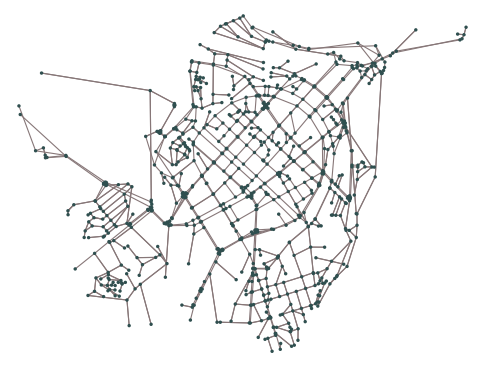

In [ ]:
# ----- Build toy MultiGraph -----
PLACE = "Kentron, Yerevan, Armenia"   # small; fast for smoke tests
NETWORK = "drive"

# ---------- download (simplify=True by default here) ----------
G = ox.graph.graph_from_place(PLACE, network_type=NETWORK, simplify=True)

# keep only the largest connected component (weak is fine for roads)
G = ox.truncate.largest_component(G, strongly=False)

keep_node = {"x", "y", "street_count"}
keep_edge = {"length", "highway", "name", "maxspeed"}

for _, d in G.nodes(data=True):
    for k in list(d.keys()):
        if k not in keep_node:
            d.pop(k, None)

for u, v, k, d in G.edges(keys=True, data=True):
    for kk in list(d.keys()):
        if kk not in keep_edge:
            d.pop(kk, None)
fig, ax = ox.plot.plot_graph(
    G,
    figsize=(6, 6),
    bgcolor="white",
    node_color="#2f4f4f",
    node_size=6,
    edge_color="#877778",
    edge_linewidth=0.8,
    show=False,
    close=False,
)